# Model Simulations
This notebook contains the code to do all the simulations for the paper

In [ ]:
using Pkg

Pkg.activate("../")

using DifferentialEquations, Plots
using Random, StatsBase, DelimitedFiles, Distributions
using SymPy, LinearAlgebra

const DifEq = DifferentialEquations

include("./Helper_scripts/julia/GLV.jl")

# Testing simualtions
test to see the code is working

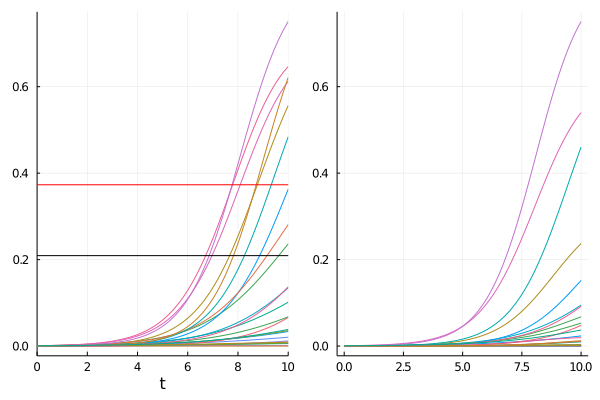

In [2]:
Random.seed!(1)

#Number of species
Nsp = 25 
#Interactions
a = -rand(Nsp,Nsp)./ (Nsp)
[a[i,i] = -1.0 for i = 1:Nsp]

#growth rate
R = rand(Nsp)
r = rand(Nsp)

#params object
p = params(r,R,a,Nsp)

C0 = rand(Nsp) ./ 1000
tspan = (0.0,10.0)
tsave = tspan[1]:0.01:tspan[2]

prob = ODEProblem(dC!, C0, tspan, p)
sol = DifEq.solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave)
uC_real = mean(sol[end])
uC_app = uC_equi(p)

p1 = plot(sol, legend = false)
hline!([uC_app], colour = "red")
hline!([uC_real], colour = "black")

p2 = plot(tsave, resp(sol,tsave)', legend = false)

plot(p1,p2)

We can see these simualtions work, giving reasonable dynamics, no weird artefacts. 

# Exponential Phase
First we look to see what the expected effect of interactions is in the exponential phase. To do so we can take a taylor series of the $\log(C)$ around $t = 0$. This gives an expression for the biomass of species $i$ at some small value of $t$ as:

\begin{align}
    \log(C_i(t)) &\approx \log(C_i(0)) +
                    +  t \frac{d \log(C_i(0))}{d t}
                    + \frac{t^2}{2} \frac{d^2 \log(C_i(0))}{d t^2}
\end{align}



Using the correct definitions we can use 'SymPy' to give the approximation in terms of the parameters in the system. One further approximation we need to use however is for the average of a function of a random variable:

$$
    \bar{f(x)} \approx f(\bar{x}) + \frac{\sigma_{x}^2}{2} \frac{d^2f(x)}{dx^2} | x = \bar{x}
$$

which gives us the value of $\frac{d\bar{C}}{dt}$.

In [6]:
include("Helper_scripts/julia/SymPy.Jl")

#89 (generic function with 1 method)

In [236]:
log_C_sol.expand().collect(ua)

   2  2  2           2                                       ⎛ 2  2    2      
aᵢᵢ ⋅t ⋅C (0)   aᵢᵢ⋅t ⋅C(0)⋅r(T)                           2 ⎜N ⋅t ⋅μ_C (0)   
───────────── + ──────────────── + aᵢᵢ⋅t⋅C(0) + t⋅r(T) + μₐ ⋅⎜───────────── + 
      2                2                                     ⎝      2         

   2    2   ⎞      ⎛       2                      2    2             2    2   
N⋅t ⋅σ_C (0)⎟      ⎜N⋅aᵢᵢ⋅t ⋅C(0)⋅μ_C(0)   N⋅aᵢᵢ⋅t ⋅μ_C (0)   N⋅aᵢᵢ⋅t ⋅σ_C (0)
────────────⎟ + μₐ⋅⎜──────────────────── + ──────────────── + ────────────────
     2      ⎠      ⎝         2                    2                  2        

      2                          ⎞            
   N⋅t ⋅μ_C(0)⋅μᵣ(T)             ⎟            
 + ───────────────── + N⋅t⋅μ_C(0)⎟ + log(C(0))
           2                     ⎠            

In [246]:
final_log_C_sol.expand().collect(ua_)

  2    2  2             2                        ⎛ 2  2        2      2       
C₀ ⋅aᵢᵢ ⋅t    C₀⋅aᵢᵢ⋅r⋅t                       2 ⎜N ⋅t ⋅μ_{C_0}    N⋅t ⋅σ_{C_0
─────────── + ─────────── + C₀⋅aᵢᵢ⋅t + r⋅t + uₐ ⋅⎜────────────── + ───────────
     2             2                             ⎝      2                2    

 2⎞      ⎛          2                  2        2          2        2      2  
} ⎟      ⎜C₀⋅N⋅aᵢᵢ⋅t ⋅μ_{C_0}   N⋅aᵢᵢ⋅t ⋅μ_{C_0}    N⋅aᵢᵢ⋅t ⋅σ_{C_0}    N⋅t ⋅μ
──⎟ + uₐ⋅⎜─────────────────── + ───────────────── + ───────────────── + ──────
  ⎠      ⎝         2                    2                   2                 

                       ⎞          
ᵣ⋅μ_{C_0}              ⎟          
───────── + N⋅t⋅μ_{C_0}⎟ + log(C₀)
 2                     ⎠          

We can also use this expression and tke the derivative w.r.t. temperature $T$ to get an estimate of the temperature sensitvity of biomass:


In [245]:
log_C_sol.diff(T).expand().collect(ua)

   2           d                2      d                    
N⋅t ⋅μₐ⋅μ_C(0)⋅──(μᵣ(T))   aᵢᵢ⋅t ⋅C(0)⋅──(r(T))             
               dT                      dT           d       
──────────────────────── + ──────────────────── + t⋅──(r(T))
           2                        2               dT      

fμWhich we can see is a funciton of the average interaction strength in the system. note it only occurs in the $t^2$ term showing that in the early stages of community assembly (when $t > t^2$) we expect there to be little effect of interacitons, but as $t$ grows, its efect with increase too. 

In [136]:

x = r_ * C0 * exp(r_*t)
x1 = x.subs(r_,ur_) + 1/2 * sr*sr * x.diff(r_,r_).subs(r_,ur_) 

         2               t⋅μᵣ          t⋅μᵣ
0.5⋅C₀⋅σᵣ ⋅t⋅(t⋅μᵣ + 2)⋅ℯ     + C₀⋅μᵣ⋅ℯ    

In [115]:
y = C0 * exp(r_*t)
y1 = ur_ * y.subs(r_,ur_) + 1/2 * sr*sr * y.diff(r_,r_).subs(r_,ur_) 

         2  2  t⋅μᵣ          t⋅μᵣ
0.5⋅C₀⋅σᵣ ⋅t ⋅ℯ     + C₀⋅μᵣ⋅ℯ    

In [124]:
(x1 + y1).expand().simplify()

   ⎛      2  2            2  2         2         ⎞  t⋅μᵣ
C₀⋅⎝0.5⋅σᵣ ⋅t ⋅μᵣ + 0.5⋅σᵣ ⋅t  + 1.0⋅σᵣ ⋅t + 2⋅μᵣ⎠⋅ℯ    

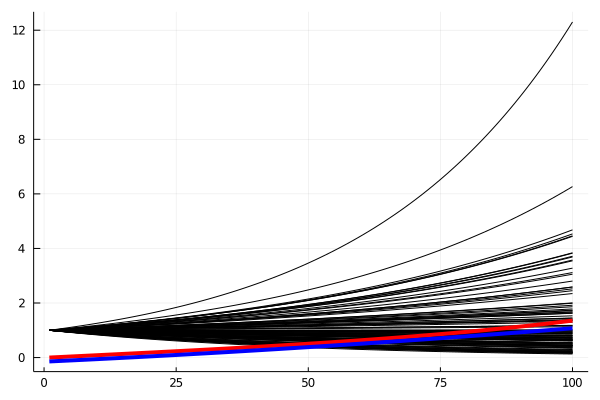

In [135]:
r_rand = randn(100)
t_vector = range(0,1,length = 100)

function f(ur,sr,t)
    (0.5*sr*t*t*ur + 0.5*sr*sr*t*t + sr*sr*t + 2*ur) * exp(t*ur)
end

mass = [exp(r*t) for r = r_rand, t = t_vector]
mass_app = [ f(mean(r_rand), var(r_rand), t) for t = t_vector]

#real cov 
real_cov = [cov(mass[:,t],r_rand) for t = eachindex(t_vector)]

plot(mass', legend = false , c = "black")
plot!(real_cov, c = "red", lw = 4)
plot!(mass_app, c = "blue", lw = 4)


#### Testing

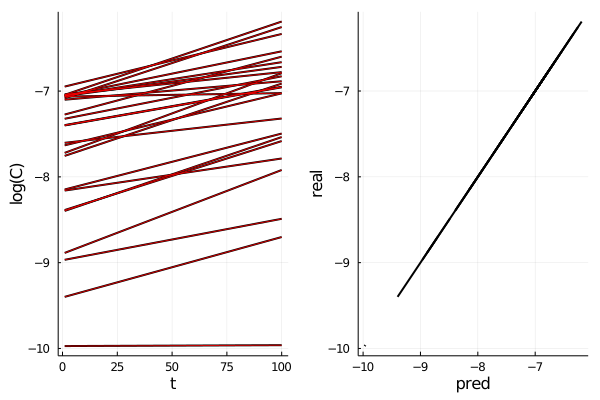

In [37]:
#test prediction on previous simulation

#get params
C0_p = sol(0.0)
aii_p = -1
r_p = sol.prob.p.r
ua_p = -(sum(sol.prob.p.a,dims=2) .+ 1)
ur_p = mean(sol.prob.p.r)
uC0_p = mean(sol(0.0))
sC0_p = std(sol(0.0))

sp_ind = 1:25
t_ind = 1:100
res = Array{Float64,2}(undef,length(t_ind),length(sp_ind))

for sp = sp_ind
    res[:,sp] .= C_log_func.(C0_p[sp],Nsp,aii_p,
                            r_p[sp],tsave[t_ind],ua_p[sp],
                            ur_p,uC0_p,sC0_p)
end

pred = res[t_ind,sp_ind]
real = log.(sol[sp_ind,t_ind])'

p1 = plot(t_ind,pred, legend = false, c = "black", lw = 2, xlab = "t", ylab = "log(C)")
plot!(t_ind,real, colour = "red", alpha = 0.8)


p2 = plot(pred,real, legend = false, c = "black", lw = 2, xlab = "pred",ylab= "real")

plot(p1,p2)

#### Temperature

So how does this work across temperature

In [38]:
include("./Helper_scripts/julia/GLV.jl")

Nsp = 50
ua_abs = 3
ua_p = range( (-ua_abs/Nsp) , (ua_abs/Nsp) ,length = 10)
sa = 1 / Nsp
aii_p = -1.0

tspan = (0.0,3.0)
tsave = tspan[1]:0.1:tspan[2]
C0_p = ones(Nsp) / 50

Nrep = 10
NTemp = 25
Temp_vec = range(5,25,length = NTemp)

R_sim = Array{Float64,4}(undef,NTemp,Nrep,length(tsave),length(ua_p))
C_sim = Array{Float64,4}(undef,NTemp,Nrep,length(tsave),length(ua_p))

R_pred = Array{Float64,4}(undef,NTemp,Nrep,length(tsave),length(ua_p))
C_pred = Array{Float64,4}(undef,NTemp,Nrep,length(tsave),length(ua_p))

print("Starting:")

for int = eachindex(ua_p)
    
    print("\r", "interaction: ",int)
    
    for N = 1:Nrep
        
        r0 = rand(Nsp)
        Er = fill(0.65,Nsp)
        
        R0 = fill(1.0, Nsp)
        ER = fill(0.65,Nsp)
        
        a0 = rand(Nsp,Nsp)
        
        for T = eachindex(Temp_vec)
            
            pT = Temp_params(r0,Er,R0,ER,ua_p[int],sa,aii_p,Nsp,N,Temp_vec[T])
            sol = sim_T(pT,C0_p, tspan, tsave)

            for t = eachindex(tsave)
                
                R_sim[T,N,t,int] = sum(resp(sol,tsave[t]))
                C_sim[T,N,t,int] = sum(sol(tsave[t]))
                
                # #lambdify parameter order -> (C0 N aii r t ua ur uC0 sC0)
                C0_p = sol(0.0)
                uC0_p = mean(sol(0.0))
                sC0_p = sqrt(one_pass_cov(sol(0.0),sol(0.0)))
                r_p = sol.prob.p.r
                ur_p = mean(sol.prob.p.r)
                R = sol.prob.p.R

                C_pred_all = exp.(C_log_func.(C0_p, Nsp, aii_p,
                                               r_p, tsave[t], ua_p[int] * Nsp,
                                              ur_p, uC0_p, sC0_p))
                
                C_pred[T,N,t,int] = sum(C_pred_all)
                R_pred[T,N,t,int] = sum(C_pred_all .* sol.prob.p.R)
            
            end
        end
    end
end

interaction: 10

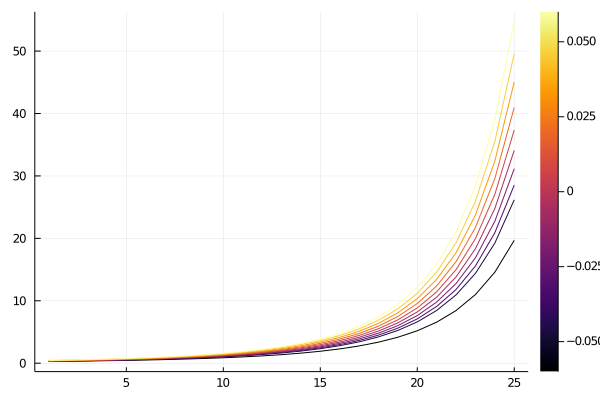

In [39]:
plot((R_pred[:,1,end,:]), legend = false, line_z = ua_p', colorbar = true)

In [40]:
using GLM,DataFrames

E_sim = Array{Float64,3}(undef,Nrep,length(tsave),length(ua_p))
E_pred = Array{Float64,3}(undef,Nrep,length(tsave),length(ua_p))
for N = 1:Nrep,t = eachindex(tsave), int = eachindex(ua_p)
    print("\r", N)
    ols = lm(@formula(Y ~ X), DataFrame(X = kT.(Temp_vec),X2 = kT.(Temp_vec).^2,Y = log.(R_sim[:,N,t,int]) ))
    E_sim[N,t,int] = coef(ols)[2]
    
    ols = lm(@formula(Y ~ X), DataFrame(X = kT.(Temp_vec),X2 = kT.(Temp_vec).^2,Y = log.(R_pred[:,N,t,int]) ))
    E_pred[N,t,int] = coef(ols)[2]
    
    
end

t =10
p1 = plot(tsave, E_sim[2,:,:],title = "simulated", legend = false,line_z = ua_p')
p2 = plot(tsave, E_pred[2,:,:], title = "predicted", legend = false,line_z = ua_p', colorbar = true)

plot(p1,p2)

10

InterruptException: InterruptException:

In [363]:
#writing data
writedlm("Data/Fig_1/E_vals/predicted_E.csv",E_pred[:,end,:],',')

In [376]:
for i = eachindex(ua_p)
    f = join(["Data/Fig_1/R_vals/R_pred_",i,".csv"])
    writedlm(f,R_pred[:,:,end,i],',')
end    

# Interaction estimates
 In this section I derive the equations to get the interactions at equilibrium

In [334]:
C1,C2 = symbols("C_1,C_2")
r1,r2 = symbols("r_1,r_2")
a11,a12,a21,a22,a = symbols("a_11,a_12,a_21,a_22,alpha")
b = symbols("beta")
Ktot,dK,K1,K2 = symbols("K_tot,Delta_K,K_1,K_2")

f1 = r1 + a11 * C1 + a*C2
f2 = r2 + a22 * C2 + a*C1


sol = linsolve((f1,f2),(C1,C2))

C1_sol = subs((sol.args[1].args[1]), (a12,a), (a21,a))
C2_sol = subs((sol.args[1].args[2]), (a12,a), (a21,a))

sol

⎧⎛-a₂₂⋅r₁ + α⋅r₂  -a₁₁⋅r₂ + α⋅r₁⎞⎫
⎪⎜──────────────, ──────────────⎟⎪
⎨⎜            2               2 ⎟⎬
⎪⎝ a₁₁⋅a₂₂ - α     a₁₁⋅a₂₂ - α  ⎠⎪
⎩                                ⎭

In [378]:
x = symbols("x")
y = C1_sol.args[1].args[1]
a_poly = expand(expand(((C1_sol+C2_sol).subs(y,x)-Ktot)*x).subs(x,y))
a_poly.collect(a)

                      2                                
-Kₜₒₜ⋅a₁₁⋅a₂₂ + Kₜₒₜ⋅α  - a₁₁⋅r₂ - a₂₂⋅r₁ + α⋅(r₁ + r₂)

In [376]:
SymPy.solve(a_poly,a)

2-element Array{SymPy.Sym,1}:
 (-r_1 - r_2 + sqrt(4*K_tot^2*a_11*a_22 + 4*K_tot*a_11*r_2 + 4*K_tot*a_22*r_1 + r_1^2 + 2*r_1*r_2 + r_2^2))/(2*K_tot)
 -(r_1 + r_2 + sqrt(4*K_tot^2*a_11*a_22 + 4*K_tot*a_11*r_2 + 4*K_tot*a_22*r_1 + r_1^2 + 2*r_1*r_2 + r_2^2))/(2*K_tot)

In [380]:
K_sol

⎧                          ⎛K₁⋅r₂⋅(K₂⋅α - r₁)  K₁⋅K₂⋅α⋅r₁ - K₂⋅r₁⋅r₂⎞⎫
⎪(0, 0), (0, K₂), (K₁, 0), ⎜─────────────────, ─────────────────────⎟⎪
⎨                          ⎜        2                    2          ⎟⎬
⎪                          ⎝ K₁⋅K₂⋅α  - r₁⋅r₂     K₁⋅K₂⋅α  - r₁⋅r₂  ⎠⎪
⎩                                                                    ⎭

In [379]:
J = [(C1*f1).diff(C1) (C1*f1).diff(C2) ; (C2*f2).diff(C1) (C2*f2).diff(C2)]
J = map(x -> subs(x, (a12,a), (a21,a)), J)
J_eq = map(x -> subs(x,(C1,C1_sol),(C2,C2_sol)).simplify(), J)



2×2 Array{SymPy.Sym,2}:
  -a_11*(a_22*r_1 - alpha*r_2)/(a_11*a_22 - alpha^2)  …  -alpha*(a_22*r_1 - alpha*r_2)/(a_11*a_22 - alpha^2)
 -alpha*(a_11*r_2 - alpha*r_1)/(a_11*a_22 - alpha^2)      -a_22*(a_11*r_2 - alpha*r_1)/(a_11*a_22 - alpha^2)

In [ ]:
D = J_eq[1,1]*J_eq[2,2] - J_eq[1,2]*J_eq[2,1]

expand(D).simplify()

In [ ]:
a_,b_,c_,d_ = symbols("a,b,c,d")

eigen([a_ b_ ; c_ d_])

In [252]:
function a_est(p,K)
    a = K
    b = (p.r[1]+p.r[2])
    c = K - (p.r[1]*p.a[2,2]) - (p.r[2]*p.a[1,1])
    
    return([(b^2 + sqrt(4*a*c)) / (2a) , (b^2 - sqrt(4*a*c)) / (2a) ])
end

function get_Ktot(p)
    (p.a[1,2]*p.r[1] - p.a[1,1]*p.r[2] + p.a[2,1]*p.r[2] - p.a[2,2]*p.r[1]) / (p.a[1,1]*p.a[2,2] - p.a[1,2]*p.a[2,1])
end

function get_Ktot_K(p)
    K = -p.r ./ [p.a[1,1],p.a[2,2]]
    b = K[1] * p.a[1,2] / p.r[1]
    
    return ((K[2]*b - K[1]) / (b^1 - 1)) + ((K[1]*b - K[2]) / (b^1 - 1))
end

get_Ktot_K (generic function with 1 method)

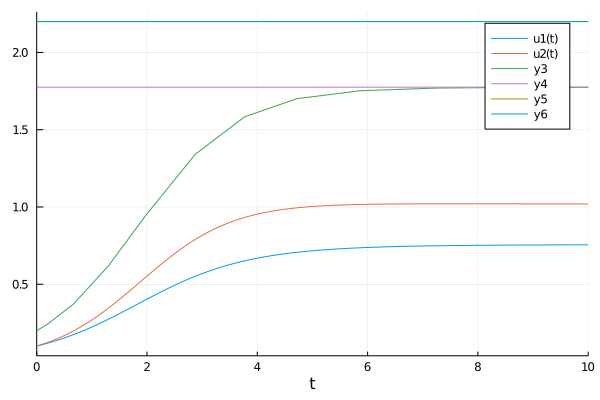

In [257]:
include("./Helper_scripts/julia/GLV.jl")

r = [1.0,1.2]
a = [-1.0 0.0;
     0.0 -1.0]

p_pair = pair_params(r,a)
x = a_est(p_pair,2.0)

p_pair = pair_params(r,[-1.0 x[2]; x[2] -1.0])

C0 = [0.1, 0.1]
tspan = (0.0,10.0)

prob = ODEProblem(dC_pair!,C0,tspan,p_pair)
sol_1 = DiffEqBase.solve(prob, Vern7() )

plot(sol_1)
plot!(sol_1.t, sum.(sol_1.u))
hline!([get_Ktot(p_pair)])
hline!([get_Ktot_K(p_pair)])
hline!([-sum(p_pair.r ./ [p_pair.a[1,1],p_pair.a[2,2]])])


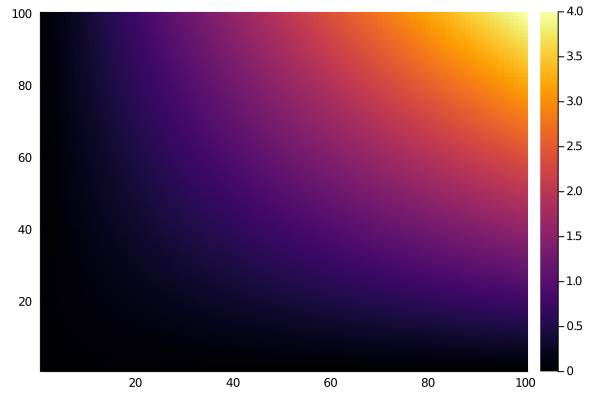

In [332]:
a = range(0,2,length = 100)

heatmap(a * a')

## Temperature vs Respiration



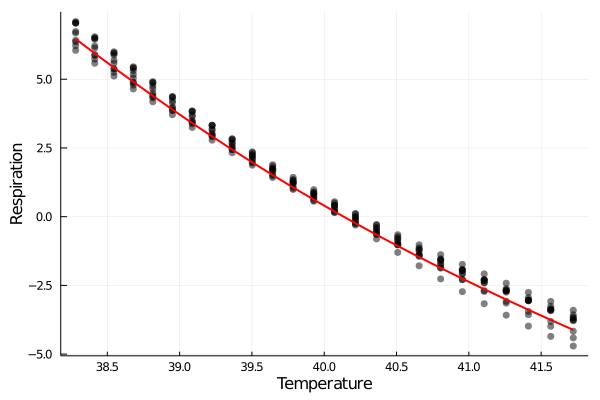

In [782]:
include("./Helper_scripts/julia/GLV.jl")

Nsp = 50
ua, sa = -1.0 / Nsp, 1.0 / Nsp

tspan = (0.0,1000.0)
tsave = tspan[1]:0.1:tspan[2]


Nrep = 10
NTemp = 25
Temp_vec = range(5,30,length = NTemp)

R_vec = Array{Float64,2}(undef,NTemp,Nrep)
pred = Array{Float64,1}(undef,NTemp)

for N = 1:Nrep
    r0 = rand(Nsp)
    Er = fill(0.65,Nsp) .+ rand(Nsp) * 2
    R0 = rand(Nsp)
    ER = fill(0.65,Nsp) .+ rand(Nsp) * 2
    
    for t = eachindex(Temp_vec)
        pT = Temp_params(r0,Er,R0,ER,ua,sa,1.0,Nsp,N,Temp_vec[t])
        sol = sim_T(pT,tspan, tsave)
        
        R_vec[t,N] = sum(resp(sol,tspan[2]))
        pred[t] = pred_ΔT(pT)
    end
    
end


p1 = scatter(kT.(Temp_vec),log.(R_vec),legend = false, 
    colour = "black", alpha = 0.5, xlab = "Temperature", ylab = "Respiration")
plot!(kT.(Temp_vec), log.(pred), colour = "red", lw = 2)

We can see that the analytical approximation (red line) works pretty well with the simulations (black dots).

In [772]:
# NTemp = 100
# Temp_vec = range(5,30,length = NTemp)

# r0 = rand(Nsp)
# Er = fill(0.65,Nsp) .+ rand(Nsp) * 2
# R0 = rand(Nsp)
# ER = fill(0.65,Nsp) .+ rand(Nsp) * 2

# #get dC @ t=0
# dC_0(sol) = sol.prob.p.r .* sol(0.0) + sum(sol(0.0) .* sol(0.0)' .* sol.prob.p.a, dims = 2)

# #app_log_biomss
# app_log(sol,t) = log.(sol(0.0)) .+ (t ./ sol(0.0)) .* dC_0(sol)
# #E approx

# res_app = Array{Float64,2}(undef,NTemp,Nsp)
# res_real = Array{Float64,2}(undef,NTemp,Nsp)

# for T = eachindex(Temp_vec)
#     #generate temp params
#     pT = Temp_params(r0,Er,R0,ER,ua,sa,1.0,Nsp,1,Temp_vec[T])
#     #simulate system at that temperature 
#     sol = sim_T(pT,tspan, tsave)
#     sol[sol[:,:] .< eps()] .= eps() #remove -ve biomass
    
#     res_real[T,:] = log.(sol(1.0))
#     #approximate biomass
#     res_app[T,:] = app_log(sol,1.0)
# end

# plot(Temp_vec, res_real[:,4], legend = false, line_z = Temp_vec, colorbar = true)

## Varying interaction strength
So what happens when we change the average stregnth of interactions in this system? The theory suggests we should see increased sensitvity as we increase the inteactions (to be more positive)

In [806]:
include("./Helper_scripts/julia/GLV.jl")
Nsp = 50

ua = [-1.0, 0.0, 0.9] ./ Nsp
sa = 1.0 / Nsp

tspan = (0.0,1000.0)
tsave = tspan[1]:1:tspan[2]

Temp_vec = range(5,30,length = 25)
#results (Temp, replicates, interactions, time)
R_vec = Array{Float64,4}(undef,25,100,3,length(tsave))
pred = Array{Float64,3}(undef,25,100,3)

for int = 1:3
    print()
    for N = 1:100
        r0 = rand(Nsp)
        Er = fill(0.65,Nsp) .+ rand(Nsp) 
        R0 = rand(Nsp)
        ER = fill(0.65,Nsp) .+ rand(Nsp)
        for T = eachindex(Temp_vec)
            pT = Temp_params(r0,Er,r0,Er,ua[int],sa,1.0,Nsp,N,Temp_vec[T])
            sol = sim_T(pT,tspan, tsave)
            
            for t = 1:length(tsave)
                R_vec[T,N,int,t] = sum(resp(sol,tsave[t]))
            end
            
            pred[T,N,int] = pred_ΔT(pT, sol)
        end
    end
end

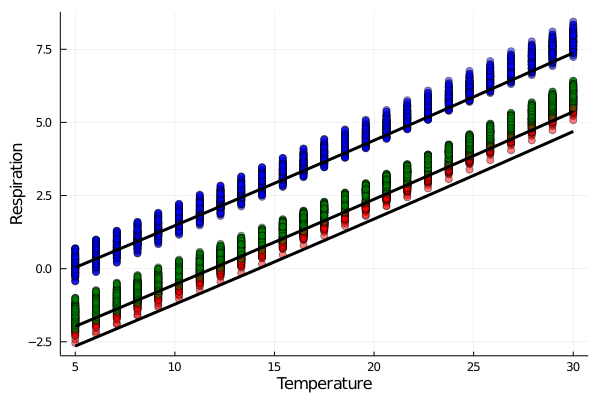

In [807]:
t = length(tsave)

scatter((Temp_vec),log.(R_vec[:,:,1,t]),legend = false,
    colour = "red", alpha = 0.5, xlab = "Temperature", ylab = "Respiration")

scatter!((Temp_vec),log.(R_vec[:,:,2,t]),legend = false, 
    colour = "green", alpha = 0.5, xlab = "Temperature", ylab = "Respiration")

scatter!((Temp_vec),log.(R_vec[:,:,3,t]),legend = false, 
    colour = "blue", alpha = 0.5, xlab = "Temperature", ylab = "Respiration")

plot!(Temp_vec,log.(pred[:,3,:]),linecolour = "black", lw = 3)

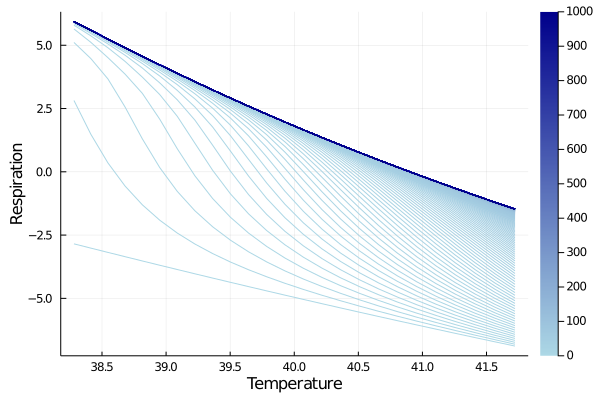

In [814]:
plot(kT.(Temp_vec),log.(R_vec[:,1,2,:]),legend = false,colorbar=true,
    colour = "red", xlab = "Temperature", ylab = "Respiration",
    line_z = (tsave)', linecolor = :blues)

In [778]:
# #term importance over time
# C = sol[:,:]
# dC = hcat(sol.(tsave,Ref(Val{1}))...)[:,:]

# growth = hcat([C[:,t] .* r for t = eachindex(tsave)]...)'
# inter = hcat([ sum(C[:,t] .* C[:,t]' .* a, dims = 2) .+ (C[:,t] .* C[:,t])  for t = eachindex(tsave)]...)'
# intra = hcat([-(C[:,t] .* C[:,t])  for t = eachindex(tsave)]...)'

# total = abs.(growth) .+ abs.(inter) .+ abs.(intra)

# grw_r = growth ./ total
# inte_r = inter ./ total
# intr_r = intra ./ total

# p1 = plot(tsave, grw_r , legend = false, ylim = (-1,1), title = "growth")
# p2 = plot(tsave, inte_r , legend = false, ylim = (-1,1), title = "inter")
# p3 = plot(tsave, intr_r , legend = false, ylim = (-1,1), title = "intra")

# # plot(tsave,total)

# plot(p1,p2,p3, layout =(@layout [a b c]), size = (900,400))

In [878]:
c = exp.(randn(100))
r = 10 .+ randn(100) 

real = (f.(c,r,0.1))
# u_real = mean(real)
# u_app = f.(mean(c),mean(r),0.1) + one_pass_cov(c,c) * (-1 + 0.1/100)

# histogram(real, labels = nothing)
# vline!([u_real], label = "real")
# vline!([u_app], label = "approx")

100-element Array{Float64,1}:
  7.61202356771219
  5.654333521375703
  8.261118923285323
  6.025589071392824
  4.463500886020363
  4.101516330709758
 18.257696267155925
  2.6275510078483535
 19.26823128089922
 12.090119827156325
 24.62040451843763
  9.355271762286504
  7.746040329601164
  ⋮
  7.149458633130815
  3.8404998864821684
 11.667051137376715
 19.64113738460658
  3.8258610175558014
  9.605111595137037
  6.1954150972243935
 18.60025953012197
 14.611654758316028
  7.350248030412746
  8.793873502927891
  9.317371129652482

# Meanfield 

First we show the meanfield is good approximation. We simulate 1000 communities and look at the correspondance of average biomass in the communities

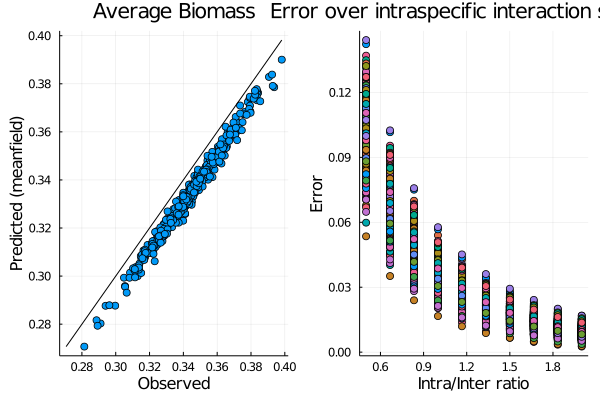

In [3]:
#check correspondance of menfield and acutal simualtions
N = 400
res = Array{Float64,2}(undef,N,2)
for i = 1:N
    res[i,:] .= meanfield_sim(i,2)
end

p1 = scatter(res[:,1],res[:,2], legend = false, xlab = "Observed", ylab = "Predicted (meanfield)", title = "Average Biomass")
plot!([minimum(res),maximum(res)], [minimum(res),maximum(res)], color = :black)

#check across intraspecific interaction strengths
N_intra = 10
intra_vec = range(0.5,2.0,length = N_intra)
res_intra = Array{Float64,3}(undef,N,N_intra,2)

for i = 1:N, j = eachindex(intra_vec)
 res_intra[i,j,:] .= meanfield_sim(i,intra_vec[j])
end

p2 = scatter(intra_vec, (res_intra[:,:,1] .- res_intra[:,:,2])', legend = false, 
    xlab = "Intra/Inter ratio", ylab = "Error", title = "Error over intraspecific interaction strength")

plot(p1,p2)

Clearly there is a good correspondance between the meanfield and GLV model. This gets worse as intraspecific interactions get weaker, this is because the $\text{Cov}(C,a_{i•}) \approx 0$ does not hold as intraspecific interactions get stronger. 

In [127]:
r,r_μ = symbols("r,r_{μ}")
a,a_μ = symbols("a,a_{μ}")
d,d_μ = symbols("d,d_{μ}")
C,C_μ = symbols("C,C_{μ}")
N = symbols("N")

C_sol = sympy.solve(C*(r + d*C + N*a_μ*C_μ),C)[2]
C_μ_sol = sympy.solve(C_sol.subs([(r,r_μ),(d,d_μ)]) - C_μ, C_μ)[1]

C_sol = expand(C_sol.subs(C_μ,C_μ_sol))


K,K_μ = symbols("K,K_μ")
C_sol.subs([(r/d,K),(r_μ/d_μ,K_μ)])


        N⋅a_{μ}⋅r_{μ}   
-K + ───────────────────
     N⋅a_{μ}⋅d + d⋅d_{μ}

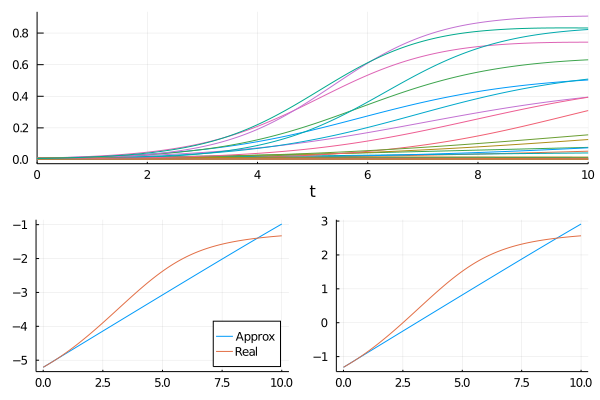

In [5]:
Random.seed!(1)

#Number of species
Nsp = 25 
#Interactions
a = -rand(Nsp,Nsp) ./ (Nsp) 
[a[i,i] = -1.0 for i = 1:Nsp]
#growth rate
r = rand(Nsp)
dR = Normal(10,100)
R = rand(dR,Nsp)
#params object
p = params(r,R,a,Nsp)


C0 = rand(Nsp) ./ 100
tspan = (0.0,10.0)
tsave = tspan[1]:0.01:tspan[2]

prob = ODEProblem(dC!, C0, tspan, p)
sol = solve(prob ,saveat = tsave)

p1 = plot(sol, legend = false)

C_bar = approx.(Ref(p),tsave,Ref(C0))
C_bar_sim = mean(hcat(sol.u...),dims = 1)[:]

p2 = plot(tsave,log.(C_bar), label = "Approx", legend = :bottomright)
plot!(tsave,log.(C_bar_sim), label = "Real")

R = sum(sol.prob.p.R * C_bar',dims = 1)[:]
R_sim = sum(sol.prob.p.R * C_bar_sim',dims = 1)[:]

p3 = plot(tsave, log.(R), legend = false)
plot!(p3, tsave, log.(R_sim))


plot(p1,p2,p3, layout = @layout [a ; b c])

In [6]:
#simualtions
N_temp = 20;Nsp = 50
T_vec = range(0,30,length = N_temp)

C0 = rand(Nsp) ./ Nsp
tspan = (0.0,5.0)

#B0
r = rand(Nsp)
R = rand(Nsp)

res = Array{Any,1}(undef,N_temp)
app = Vector{Float64}(undef,N_temp)
t_diff = Vector{Float64}(undef,N_temp)

a = (rand(Nsp,Nsp) .- 0.5) ./ Nsp
[a[i,i] = -1/Nsp for i = 1:Nsp]

# t = 1
for t = eachindex(T_vec)
    r_t = boltz.(r,0.65,T_vec[t])
    R_t = boltz.(R,0.65,T_vec[t])
    p = params(r_t,R_t,a,Nsp)
    
    prob = ODEProblem(dC!, C0, tspan, p)
    res[t] = solve(prob)
    
    T_diff = ( 1/(k*(273.15+T_vec[t])) ) - ( 1/(k*(273.15+20)) )
    t_diff[t] = T_diff

    ψ = mean((sum(a,dims = 2) .+ 1/Nsp) / (Nsp-1))
    app[t] = app_E(mean(C0),mean(r),0.65,T_diff,1.0,ψ)
end

LoadError: MethodError: objects of type Float64 are not callable

In [575]:
app_E(mean(C0),mean(r),0.65,0,1.0,0)

0.33336956487734887

In [576]:
 T_diff = (1/(k*T_vec[])) - (1/(k*(273.15+20)))

Inf

In [434]:
#interactions directory
f = "../data/Simulations/interaction_estimates"

#read file names
files = readdir(f)
files = files[occursin.("T.csv",files)]

#read metadata
meta = readdlm(joinpath(f,"metadata.csv"),',')

#read files into dictionary 
data = Dict(replace(files[i],".csv" => "") => readdlm(joinpath(f,files[i]),',') for i = eachindex(files))

#get unique temperature and pairwise combos
temp = unique(meta[2:end,2])
pair = unique(meta[2:end,1])

#pre generate r + R arrays
r_array = rand(5,100) .* 100
R_array = rand(5,100)

#allotcate params array 
param = Array{Any,3}(undef,length(temp),2,100)

for evo = 1:2
    for t = eachindex(temp) #loop through each temperature
      temp_str = join([temp[1],"T"])
      for rep = 1:100 #replicates
        #allocate interaction matrix    
        a = zeros(5,5)    
        #allocate growth    
        r = boltz(r_array[:,rep],0.65,temp[t])
        R = boltz(R_array[:,rep],0.65,temp[t]) 
            
        for p = eachindex(pair)
          pair_str = replace(pair[p]," " => "_")
          ind = replace(parse.(Int,split(pair_str,"_")),2 => 1, 15 => 2, 18 => 3, 20 => 4, 23 => 5)     
          int = data[join([pair_str,"_",temp_str])][rep+1,evo+2]
          x,y = ind[1],ind[2]
          a[y,x] = int
          a[x,y] = int
        end
        [a[i,i] = -r[i] ./ (1e7) for i = 1:5]    
            
        param[t,evo,rep] = params(r,R,a,5)
      end
    end
end


In [607]:
tspan = (0.0,1000.0)
tsave = tspan[1]:1:tspan[2]
#allocate sols array
sols = Array{Any,3}(undef,length(temp),2,100)

for t = eachindex(temp), evo = 1:2, rep = 1:100
    print("\r",rep)
    C0 = rand(5)
    prob = ODEProblem(dC!, C0, tspan, param[t,evo,rep])
    sols[t,evo,rep] = solve(prob ,saveat = tsave)
end

100

# Testing Meanfield approximation

here I test if the approximations work

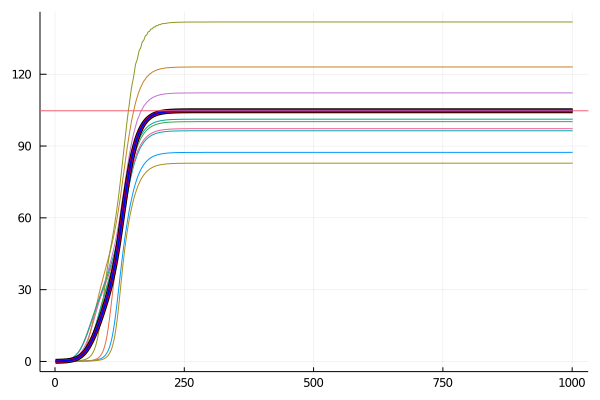

In [7]:
Random.seed!(1)

include("./Helper_scripts/julia/GLV.jl")

#Number of species
Nsp = 10
#Interactions
a = (rand(Nsp,Nsp)) ./ (Nsp) 
[a[i,i] = -0.5 for i = 1:Nsp]
ψ = (sum(a,dims=2) .+ 0.5)[:]

#growth rate
r = rand(Nsp) .* 10
R = rand(Nsp)

#params object
p = params_mean(r,R,a,ψ,Nsp)


C0 = rand(Nsp) * 0.1
append!(C0,[mean(C0),mean(C0)])
tspan = (0.0,10.0)
tsave = tspan[1]:0.01:tspan[2]

prob = ODEProblem(dC_meanfield!, C0, tspan, p)
sol = solve(prob ,saveat = tsave)

mean_real = mapslices(x -> mean(x), sol[1:Nsp,:], dims = 1)[:]

p1 = plot(sol[1:Nsp,:]', legend = false)
plot!(mean_real,linewidth = 5, color = "black")
plot!(sol[end-1,:], linewidth = 3, color = "red")
plot!(sol[end,:], linewidth = 2, color = "blue")
hline!([uC_equi(p)])

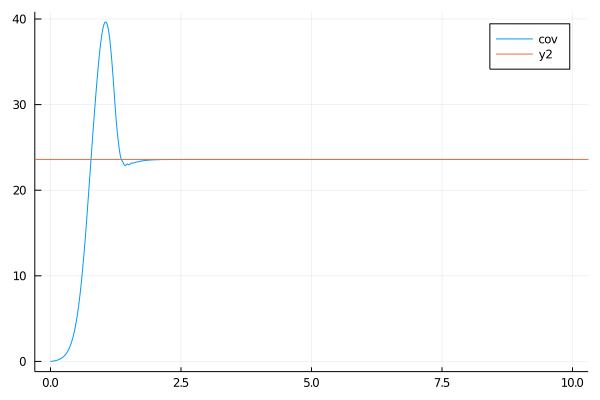

In [196]:
cov_r = mapslices(x -> one_pass_cov(x,r), sol[1:Nsp,:], dims = 1) 
# cov_ψ = mapslices(x -> one_pass_cov(x,ψ), sol[1:Nsp,:], dims = 1) 

p1 = plot(tsave, cov_r[:], labels = "cov")
# plot!(p1, log.(tsave[2:end]), diff(cov_r[:]), labels = "d(cov)")

hline!([cov_test(C_equi(p),r)])

# p2 = plot(log.(tsave), cov_ψ[:], legend = false)
# plot!(p2, log.(tsave[2:end]), diff(cov_ψ[:]))

# plot(p1,p2)

In [191]:
one_pass_cov(C_equi(p),r)

23.592062324539985

In [195]:
cov_test(C_equi(p),r)

23.59206232453994

In [112]:
#generate data to cov
function generate_cov_data(id; output = false)
    
    Random.seed!(id)
    
    #Number of species
    Nsp = 10
    #Interactions
    a = (rand(Nsp,Nsp).-0.5) ./ ((Nsp)*(rand()*100))
    [a[i,i] = -0.5 for i = 1:Nsp]
    ψ = (sum(a,dims=2) .+ 0.5)[:]

    #growth rate
    r = rand(Nsp) .* (rand()*100)
    R = rand(Nsp)

    #params object
    p = params_mean(r,R,a,ψ,Nsp)


    C0 = rand(Nsp) * 0.1
    append!(C0,[mean(C0),mean(C0)])
    tspan = (0.0,1e6)
#     tsave = tspan[1]:0.1:tspan[2]

    prob = ODEProblem(dC_meanfield!, C0, tspan, p)
    sol = solve(prob ,saveat = tsave)
    cov_r = mapslices(x -> one_pass_cov(x,r+ψ), sol[1:Nsp,:], dims = 1)[:] 
    
    res = hcat(cov_r, tsave,
                repeat([mean(C0)],length(tsave)),
                repeat([var(C0)],length(tsave)),
                repeat([mean(r)],length(tsave)),
                repeat([var(r)],length(tsave)),
                repeat([mean(ψ)],length(tsave)),
                repeat([var(ψ)],length(tsave)),
                repeat([id],length(tsave)))
    
    if output
        return(res,p)
    else
        return(res)
    end
    
    
end

generate_cov_data (generic function with 1 method)

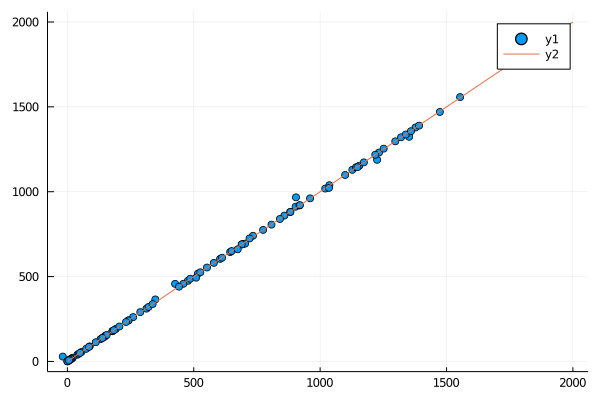

In [194]:
include("Helper_scripts/julia/GLV.jl")

#testing cov_equi
cov_res = Array{Float64,2}(undef,100,2)

for i = 1:100
    x,y = generate_cov_data(i,output = true)
    
    cov_res[i,1] = x[end,1]
    cov_res[i,2] = cov_rc(y)    
end


scatter(cov_res[:,1],cov_res[:,2])
plot!([0,2000],[0,2000])

In [74]:
train = Vector{Any}(undef,100)
test = Vector{Any}(undef,100)
for i = 1:100
    print("\r", i)
    train[i] = generate_cov_data(i,output = false)
    test[i] = generate_cov_data(i*2,output = false)
end

writedlm("../data/Simulations/symbolic_reggresion/train.csv", vcat(train...), ',')
writedlm("../data/Simulations/symbolic_reggresion/test.csv", vcat(test...), ',')

100

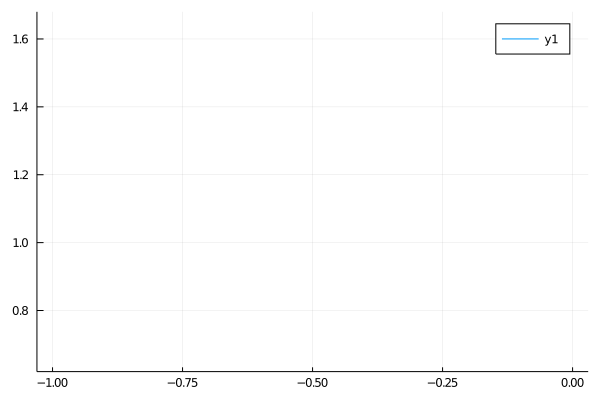

In [57]:
E

10-element Array{Float64,1}:
 0.23603334566204692
 0.34651701419196046
 0.3127069683360675
 0.00790928339056074
 0.4886128300795012
 0.21096820215853596
 0.951916339835734
 0.9999046588986136
 0.25166218303197185
 0.9866663668987996